# Simple Color Detection

Kevin J. Walchko, created 15 Jan 2017

---

We want to develop a simple image processing routine that will detect a given color in an image. This idea can then be expanded to detecting a pattern of colors based off a histogram model. We will also take a look at OpenCV's blob library which can help you find things.

Note that in this lesson I will show examples that work, they will not work for all images, lighting and backgrounds. You typically have to develop a robust system or things will go wrong. This lesson lays the foundation for robots tracking items (we'll look at tennis balls today) or how football draws the 1st down line in real-time on TV. The example below from the earlier days has issues, but it is pretty good today.

![](pics/football.jpg)

## Objectives

- detect a color in an image
- detect a color model in an image
- basic understanding of blobs in computer vision

## References

- [Blob detection](https://www.learnopencv.com/blob-detection-using-opencv-python-c/)
- [Wikipedia HSV](https://en.wikipedia.org/wiki/HSL_and_HSV)
- [OpenCV Python documentation](http://docs.opencv.org/trunk/d6/d00/tutorial_py_root.html)
- [List of color spaces and their uses](https://en.wikipedia.org/wiki/List_of_color_spaces_and_their_uses)
- [Website to understand RGB and HSV colors](http://colorizer.org/)

## Setup

In [47]:
%matplotlib inline

In [48]:
from __future__ import print_function
from __future__ import division
import numpy as np
from matplotlib import pyplot as plt
import cv2

In [49]:
import pylab                                 
pylab.rcParams['figure.figsize'] = (10.0, 18.0)

## Color Detection

Steps:

1. Convert image from RGB to a better colorspace, here we use HSV
1. Threshold the image between and upper lower HSV bounds
1. Use `erode` to first remove small false positives
1. Use `dilate` to close holes in the image blob.

Note, step 3 and 4 (erode then dilate) was also called openning when we talked about morphological operators earlier.

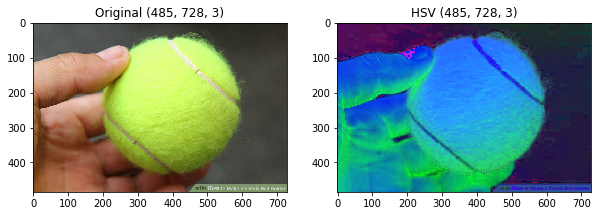

In [50]:
# read in image and convert to HSV
# im = cv2.imread('tennis/tennis_test.jpg')
im = cv2.imread('tennis/test6.jpg')
hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.title('Original {}'.format(im.shape))

plt.subplot(1,2,2)
plt.imshow(hsv)
plt.title('HSV {}'.format(hsv.shape));

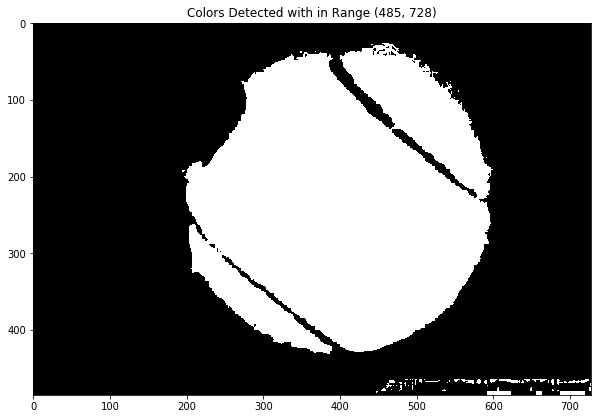

In [51]:
# find colors in range
greenLower = (29, 86, 6)
greenUpper = (64, 255, 255)
detect = cv2.inRange(hsv, greenLower, greenUpper)

plt.imshow(detect, cmap='gray')
plt.title('Colors Detected with in Range {}'.format(detect.shape));

Questions:

1. Why are we using HSV ... what value does it add to this process?
1. Did we detect anything else besides the tennis ball?
1. What could we have done to avoid that?
1. Can you see any similarity between what we are doing and how you understand a green screen to work? If so, what?

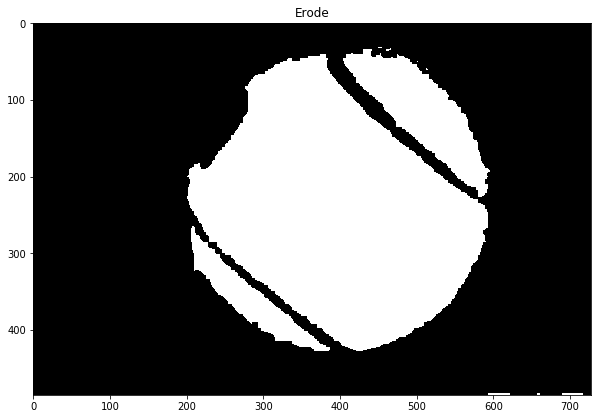

In [41]:
# get rid of stray and noisy pixels
erode = cv2.erode(detect, None, iterations=2)
plt.imshow(erode, cmap='gray')
plt.title('Erode');

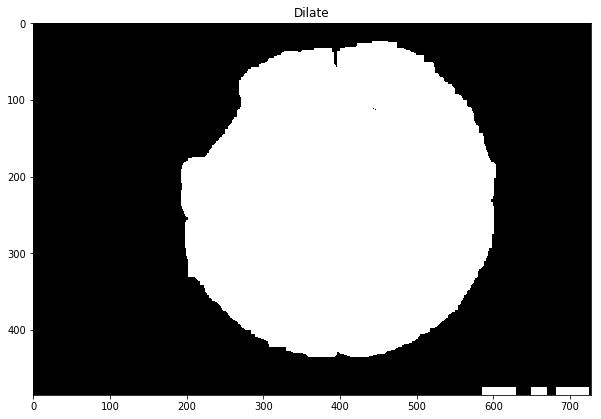

In [42]:
# close up small holes
dilate = cv2.dilate(erode, None, iterations=8)
plt.imshow(dilate, cmap='gray')
plt.title('Dilate');

mask = dilate

Notice in the first image, there are some detects in places that are not the ball ... nothing is perfect and you typically  have some small left overs to clean up. So let's find things that are circular, since this is a tennis ball and should be round.

In [43]:
# search image for contours, think lines on a contour plot. It should be easy here.
mask = dilate
cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]

print('Found {} objects'.format(len(cnts)))

# find the largest contour in the mask, then use
# it to compute the minimum enclosing circle and
# centroid
c = max(cnts, key=cv2.contourArea)
((x, y), radius) = cv2.minEnclosingCircle(c)
x, y, radius = int(x), int(y), int(radius)
print('Circle center: ({}, {})   radius: {} pixels'.format(x, y, radius))

Found 4 objects
Circle center: (392, 225)   radius: 217 pixels


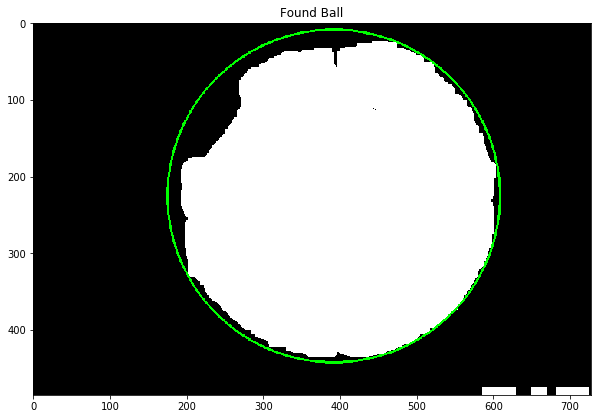

In [44]:
# now convert the image from grayscale back to color so we can
# draw colors on it ... this is only necessary for display
cmask = cv2.cvtColor(mask,cv2.COLOR_GRAY2RGB)

# draw circle on image
cv2.circle(cmask,(x,y),radius,(0,255,0),2)

plt.imshow(cmask)
plt.title('Found Ball');

# Blob Detection

OpenCV has a simple blob detector built into it. However, the performance, at least on the python side, seems to be a little finicky, so you might have to play with the parameters to get them to work right.

![](blobs/blob_detection.jpg)

The steps are:

1. Convert the source image to binary images by applying thresholding with several thresholds from minThreshold (inclusive) to maxThreshold (exclusive) with distance thresholdStep between neighboring thresholds.
1. Extract connected components from every binary image by findContours and calculate their centers.
1. Group centers from several binary images by their coordinates. Close centers from one group that corresponds to one blob, which is controlled by the minDistBetweenBlobs parameter.
1. From the groups, estimate final centers of blobs and their radii and return as locations and sizes of keypoints.

The detector performs several filtrations of the discovered blobs. The default appears to be searching for darker (i.e., black) blobs which is the inverse of what you often think of.

<img src="blobs/BlobTest.jpg" width="400px">

Available filtrations:

- **Color** (**This seems to be broken**). This filter compares the intensity of a binary image at the center of a blob to blobColor. If they differ, the blob is filtered out. 
    - blobColor = 0 to extract dark blobs
    - blobColor = 255 to extract light blobs.
- **Area**. Extracted blobs have an area between minArea (inclusive) and maxArea (exclusive).
- **Circularity**. Extracted blobs have circularity ($\frac{4∗\pi∗Area}{perimeter^2}$) between minCircularity (inclusive) and maxCircularity (exclusive).
    - A circle has a circularity of 1
    - A regular hexagon has higher circularity than say a square
- **Ratio of the minimum inertia to maximum inertia**. All you have to know is that this measures how elongated a shape is. E.g. for a circle, this value is 1, for an ellipse it is between 0 and 1, and for a line it is 0. Extracted blobs have this ratio between minInertiaRatio (inclusive) and maxInertiaRatio (exclusive). [Moments of inertia](https://en.wikipedia.org/wiki/List_of_moments_of_inertia).
<img src="blobs/inertia.jpg" width="400px">
- **Convexity**. Extracted blobs have convexity ($\frac{area}{area_{blob-convex-hull}}$) between minConvexity (inclusive) and maxConvexity (exclusive).
<img src="blobs/concave-convex.jpg" width="400px">

Default values of parameters are tuned to extract dark circular blobs, so you will usually need to invert a white mask image.

```python
params = cv2.SimpleBlobDetector_Params()

# color - doesn't seem to work
# params.blobColor = 255

# Change thresholds - levels
params.minThreshold = 0  # inclusive
params.maxThreshold = 1  # exclusive
params.thresholdStep = 1

# Filter by Area.
params.filterByArea = True
params.minArea = 1500

# Filter by Circularity - doesn't seem very precise
params.filterByCircularity = True
params.maxCircularity = 1.2
params.minCircularity = .7

# Filter by Convexity
params.filterByConvexity = True
params.minConvexity = 0.87

# Filter by Inertia
params.filterByInertia = True
params.minInertiaRatio = 0.01

detector = cv2.SimpleBlobDetector_create(params)
keypoints = detector.detect(gray)
im_with_keypoints = cv2.drawKeypoints(
    frame,
    keypoints,
    None,  # output image
    (0,0,255),
    cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.imshow(im_with_keypoints)
```

In [ ]:
def printParams(params):
    # this is just a helper function to print a lot of stuff nicely
    # it doesn't do anything really
    print('[Parameters]')
    print('  Repeatability: {}'.format(params.minRepeatability))
    print('  Color[{}]'.format(params.filterByColor))
    print('  Threshold[{}]: {}:{}'.format(
        params.thresholdStep, 
        params.minThreshold, 
        params.maxThreshold))
    print('  Inertia[{}]: {}/{}'.format(
        params.filterByInertia, 
        params.minInertiaRatio, 
        params.minInertiaRatio))
    print('  Area[{}]: {}/{}'.format(
        params.filterByArea,
        params.minArea,params.maxArea))
    print('  Convexity[{}]: {}/{}'.format(
        params.filterByConvexity,
        params.minConvexity,
        params.maxConvexity))
    print('  Circularity[{}]: {}/{}'.format(
        params.filterByCircularity,
        params.minCircularity,
        params.maxCircularity))

[Parameters]
  Repeatability: 2
  Color[True]
  Threshold[10.0]: 50.0:100.0
  Inertia[False]: 0.10000000149/0.10000000149
  Area[False]: 25.0/5000.0
  Convexity[True]: 0.949999988079/3.40282346639e+38
  Circularity[False]: 0.800000011921/3.40282346639e+38
key points found: 1
> key point: (384.59326171875, 236.72251892089844) 409.900268555


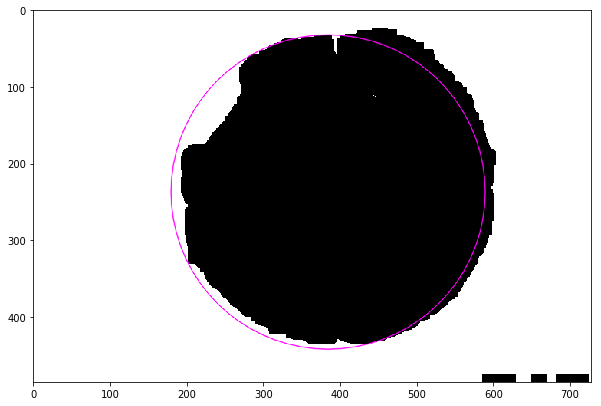

In [45]:
params = cv2.SimpleBlobDetector_Params()

# Change thresholds
# params.minThreshold = 10;
# params.maxThreshold = 200;
# params.minThreshold = 10;
params.maxThreshold = 100;
 
# Filter by Area.
params.filterByArea = False
# params.minArea = 1500
 
# Filter by Circularity
# params.filterByCircularity = True
# params.minCircularity = .5
 
# Filter by Convexity
# params.filterByConvexity = False
# params.minConvexity = 0.8
 
# Filter by Inertia
params.filterByInertia = False
# params.minInertiaRatio = 0.01

# inv_mask2 = 255-mask
# inv_mask = 255*np.ones((300,300), dtype=np.uint8)
# print(inv_mask.shape)


# inv_mask[0:183, 0:275] = inv_mask2
inv_mask = 255-mask

printParams(params)

detector = cv2.SimpleBlobDetector_create(params)

keypoints = detector.detect(inv_mask)
print('key points found: {}'.format(len(keypoints)))
for k in keypoints:
    print('> key point: {} {}'.format(k.pt, k.size))
#     print(k.size)
#     print(k.pt)
#     cv2.circle(blob_img, (int(k.pt[0]), int(k.pt[1])), int(k.size), (255,0,255))

blob_img = cv2.cvtColor(inv_mask,cv2.COLOR_GRAY2RGB)

im_with_keypoints = cv2.drawKeypoints(
    blob_img,
    keypoints,
    None,  # output image
    (255,0,255),
    cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.imshow(im_with_keypoints);

# Histogram Detection

## Where's Mario?

Let's take a look at trying to find Mario in some images. First we need to convert the image from RGB to HSV color space.
* The **hue** (H) of a color refers to which pure color it resembles. All tints, tones and shades of red have the same hue. Hues are described by a number that specifies the position of the corresponding pure color on the color wheel, as a fraction between 0 and 1. Value 0 refers to red; 1/6 is yellow; 1/3 is green; and so forth around the color wheel.
* The **saturation** (S) of a color describes how white the color is. A pure red is fully saturated, with a saturation of 1; tints of red have saturations less than 1; and white has a saturation of 0.
* The **value** (V) of a color, also called its lightness, describes how dark the color is. A value of 0 is black, with increasing lightness moving away from black

A good resource for understanding RGB and HSV is [colorizer.org](http://colorizer.org/) where you can play with some sliders and see how it changes the color in different color spaces.

For HSV, Hue range is [0,179], Saturation range is [0,255] and Value range is [0,255]. Different softwares use different scales. So if you are comparing OpenCV values with them, you need to normalize these ranges.   [ref](http://docs.opencv.org/trunk/df/d9d/tutorial_py_colorspaces.html)

## Why?

The big reason is that it separates color information (chroma) from intensity or lighting (luma). Because value is separated, you can construct a histogram or thresholding rules using only saturation and hue. This in theory will work regardless of lighting changes in the value channel. In practice it is just a nice improvement. Even by singling out only the hue you still have a very meaningful representation of the base color that will likely work much better than RGB. The end result is a more robust color thresholding over simpler parameters.

Hue is a continuous representation of color so that 0 and 360 are the same hue which gives you more flexibility with the buckets you use in a histogram. Geometrically you can picture the HSV color space as a cone or cylinder with H being the degree, saturation being the radius, and value being the height. 

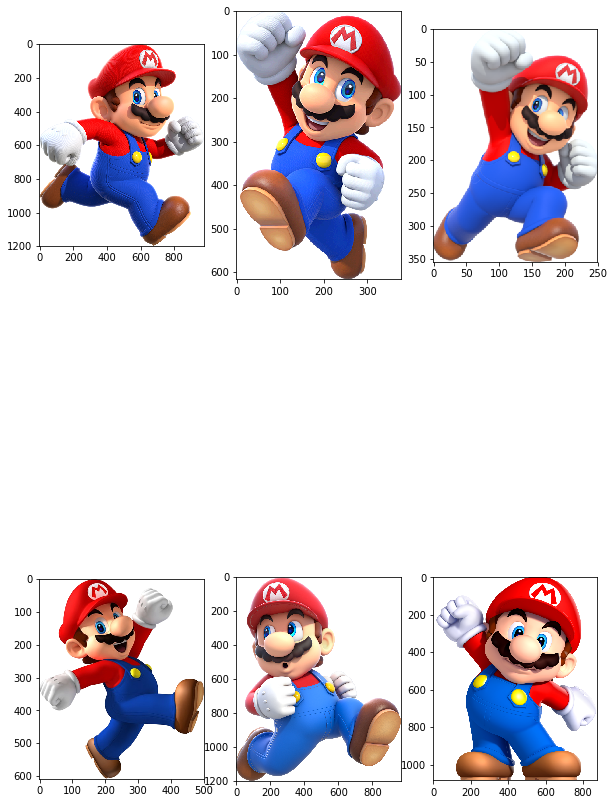

In [25]:
images = ['hist_pics/mario-1.png',
          'hist_pics/mario-2.png',
          'hist_pics/mario-3.png',
          'hist_pics/mario-4.png',
          'hist_pics/mario-5.png',
          'hist_pics/mario-6.png']
rgb = []
for image in images:
    i = cv2.imread(image, cv2.IMREAD_COLOR)
    i = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)  # pretty images
    rgb.append(i)

plt.subplot(2,3,1)
plt.imshow(rgb[0]);
plt.subplot(2,3,2)
plt.imshow(rgb[1]);
plt.subplot(2,3,3)
plt.imshow(rgb[2]);
plt.subplot(2,3,4)
plt.imshow(rgb[3]);
plt.subplot(2,3,5)
plt.imshow(rgb[4]);
plt.subplot(2,3,6)
plt.imshow(rgb[5]);

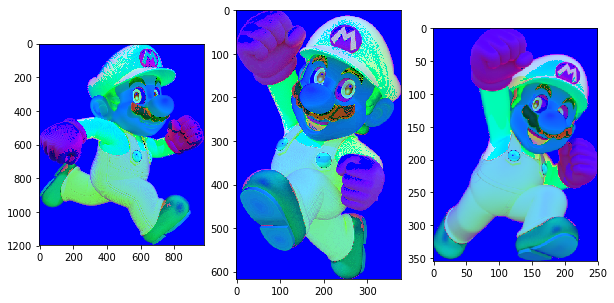

In [26]:
hsv = []
for i, image in enumerate(rgb):
    img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv.append(img)

# we will just plot the first 3, not all 6
plt.subplot(1,3,1)
plt.imshow(hsv[0]);
plt.subplot(1,3,2)
plt.imshow(hsv[1]);
plt.subplot(1,3,3)
plt.imshow(hsv[2]);

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

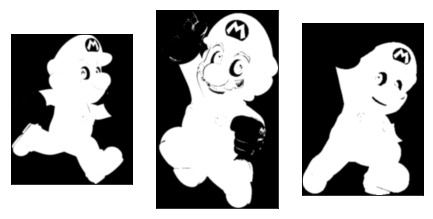

In [27]:
# let's define a mask to block out things we don't want
# since our back ground is white hsv = [x,0,255] where is x is don't care
# white is s=0, v=255
masks = []
for image in hsv:
    h,s,v = cv2.split(image)
#     ret,vv = cv2.threshold(v,250,255,cv2.THRESH_BINARY)
#     masks.append(vv)
    ret,ss = cv2.threshold(s,50,255,cv2.THRESH_BINARY)
    masks.append(ss)
#     ss = cv2.merge((ss,ss,ss))

plt.subplot(1,4,1)
plt.imshow(masks[0], cmap = 'gray', interpolation = 'bicubic');
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.subplot(1,4,2)
plt.imshow(masks[1], cmap = 'gray', interpolation = 'bicubic');
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.subplot(1,4,3)
plt.imshow(masks[2], cmap = 'gray', interpolation = 'bicubic');
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
# plt.colorbar();
# plt.subplot(1,4,4)
# plt.imshow(masks[0]);

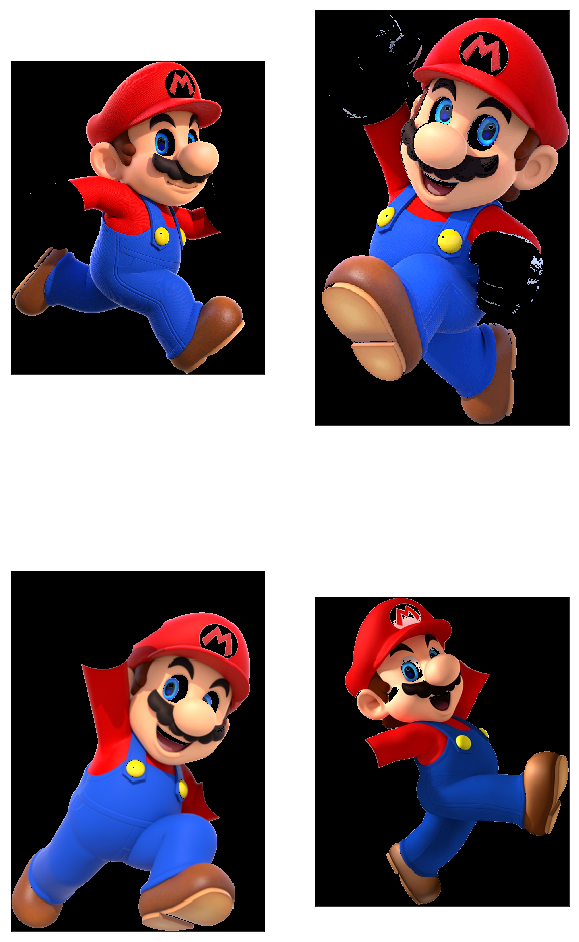

In [28]:
# let's take a look at our masks and see what shows through
tmp = []
for i in range(len(masks)):
    ret = cv2.bitwise_and(rgb[i], cv2.merge((masks[i],masks[i],masks[i])))
    tmp.append(ret)
plt.subplot(2,2,1)
plt.imshow(tmp[0]);
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.subplot(2,2,2)
plt.imshow(tmp[1]);
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.subplot(2,2,3)
plt.imshow(tmp[2]);
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.subplot(2,2,4)
plt.imshow(tmp[3]);
plt.xticks([]), plt.yticks([]);  # to hide tick values on X and Y axis

## Histograms

Let's use OpenCV's histogram function to create them.

    cv2.calcHist(images, channels, mask, histSize, ranges)

1. **images:** This is the image that we want to compute a histogram for. Wrap it as a list: [myImage].
2. **channels:** A list of indices, where we specify the index of the channel we want to compute a histogram for. To compute a histogram of a grayscale image, the list would be [0]. To compute a histogram for all three hue, saturation, and value channels, the channels list would be [0, 1, 2].
3. **mask:** I haven’t covered masking yet, but essentially, a mask is a uint8  image with the same shape as our original image, where pixels with a value of zero are ignored and pixels with a value greater than zero are included in the histogram computation. Using masks allow us to only compute a histogram for a particular region of an image. For now, we’ll just use a value of None for the mask.
4. **histSize:** This is the number of bins we want to use when computing a histogram. Again, this is a list, one for each channel we are computing a histogram for. The bin sizes do not all have to be the same. Here is an example of 32 bins for each channel: [32, 32, 32].
5. **ranges:** The range of possible pixel values. Normally, this is [0, 256] for each channel, but if you are using a color space other than RGB (such as HSV), the ranges might be different.

In [29]:
class hsvHistogram(object):
    """
    This class creates and holds the histogram information of a HSV image. It
    also is used to find our target in a given image. This class is designed
    to construct a 2D histogram looking a t hue and saturation, but not value.
    """
    hist = None
    bins = None
    def __init__(self, bins):
        self.bins = bins
        self.kernel = np.ones((5,5),np.uint8)
        
    def calcHist(self, im_array, masks=None):
        """
        Create a histogram from just images, no arrays
        """
        hist = cv2.calcHist(
            im_array,
            [0, 1],
            masks,
            [self.bins, self.bins],
            [0,180, 0 ,256]
        )
        self.hist = hist
        return hist
        
    def calcHistMask(self, im_array, masks):
        """
        Create a histogram from just images and an array of masks
        """
        hist = self.calcHist([im_array[0]], masks[0])
        for i in range(1, len(im_array)):
            h = self.calcHist([im_array[i]], masks[i])
            hist += h
            
        self.hist = hist
        return hist
    
    def normalize(self):
        cv2.normalize(self.hist,self.hist,0,self.bins,cv2.NORM_MINMAX)
        
    def find(self, test, threshold=3):
        """
        test - target image
        threshold - a tunning parameter
        """
        if self.hist is None:
            print('Need to init histogram first!')
            return 1
        
        dst = cv2.calcBackProject(
            [test],
            [0, 1],
            self.hist,
            [0,180, 0 ,256],
            1
        )
        
        disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
        cv2.filter2D(dst,-1,disc,dst)

        # cv2.threshold(image, low, high, method)
        ret, thresh = cv2.threshold(dst,threshold,255,cv2.THRESH_BINARY)

        # morphological/blobify --------
        # thresh = cv2.erode(thresh, self.kernel)
        # thresh = cv2.dilate(thresh, self.kernel)
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, self.kernel)
        return thresh
    
    def plot(self):
#         plt.plot(np.linspace(0,180,roiHist.bins), roiHist.hist)
#         plt.grid(True)
#         plt.xlabel('Hue')
        plt.imshow(self.hist,interpolation = 'nearest')
        plt.ylabel('Hue [0-179]')
        plt.xlabel('Saturation [0-255]')
        plt.title('Histogram')
        plt.colorbar()

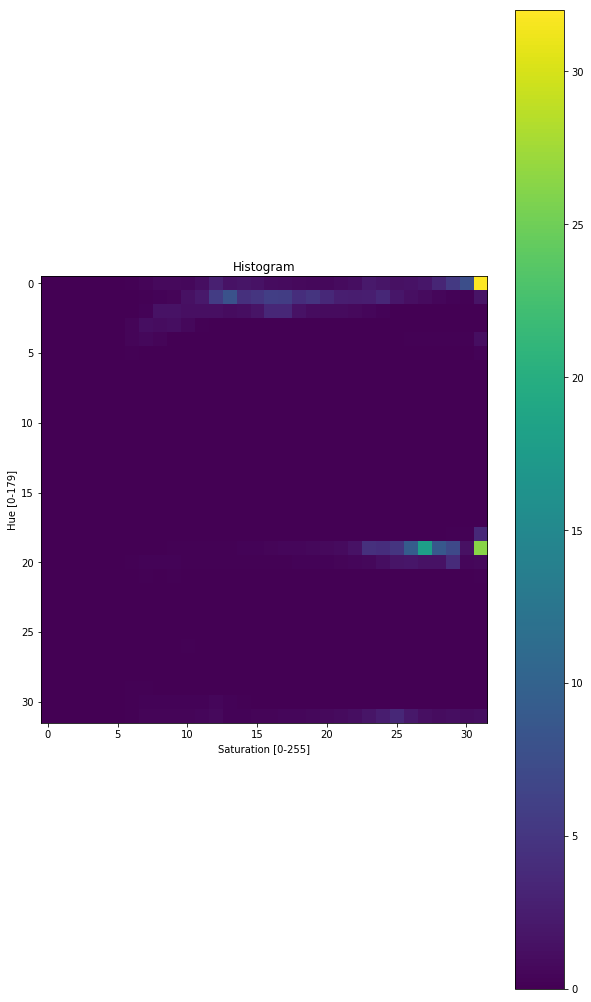

In [30]:
roiHist = hsvHistogram(32)
# roiHist.calcHist([hsv[1]], masks[1])
roiHist.calcHistMask(hsv, masks)
roiHist.normalize()
roiHist.plot()

# Test

Can we find the target image in another picture? The results aren't perfect, but we definately find our target. Now to be fair, these are synthetic images and the artists used the same colors for multiple characters, so I am impressed it worked at all.

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

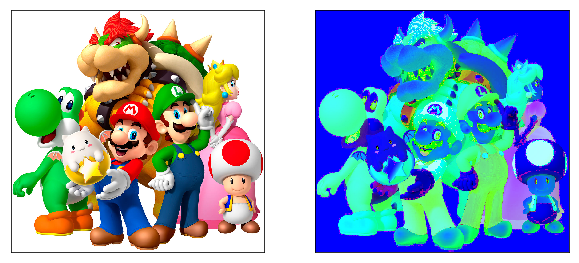

In [31]:
test_rgb = cv2.imread('hist_pics/mario-test2.jpg')
# test_rgb = rgb[0]
test_rgb = cv2.cvtColor(test_rgb, cv2.COLOR_BGR2RGB)  # make pretty for ipython
test_hsv = cv2.cvtColor(test_rgb, cv2.COLOR_RGB2HSV)  # now convert to HSV

plt.subplot(1,2,1)
plt.imshow(test_rgb);
plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2)
plt.imshow(test_hsv);
plt.xticks([]), plt.yticks([])

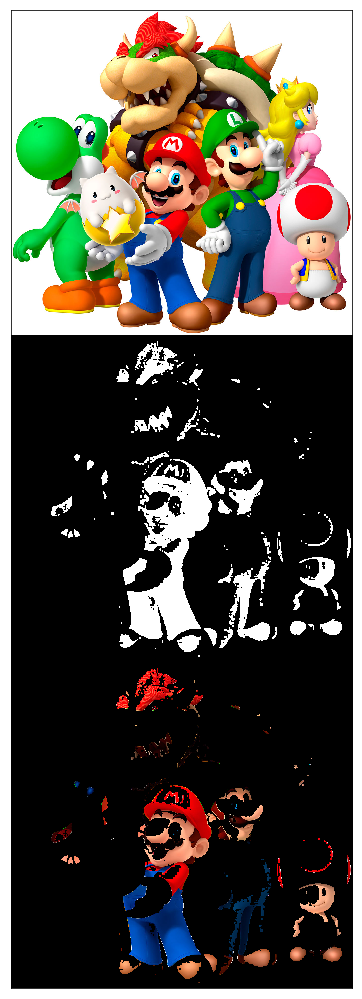

In [32]:
thresh = roiHist.find(test_hsv, 50)
thresh = cv2.merge((thresh,thresh,thresh))  # make 3 channels

# plot ----------
res = cv2.bitwise_and(test_rgb,thresh)
pics = np.vstack((test_rgb,thresh,res))
plt.imshow(pics);
plt.xticks([]), plt.yticks([]);

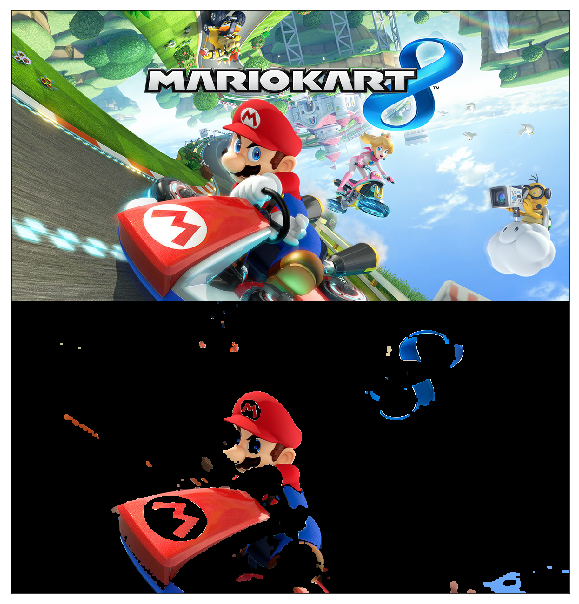

In [33]:
test_rgb = cv2.imread('hist_pics/mario-test4.jpg')
test_rgb = cv2.cvtColor(test_rgb, cv2.COLOR_BGR2RGB)  # make pretty for ipython
test_hsv = cv2.cvtColor(test_rgb, cv2.COLOR_RGB2HSV)  # now convert to HSV
thresh = roiHist.find(test_hsv, 15)
thresh = cv2.merge((thresh,thresh,thresh))  # make 3 channels
res = cv2.bitwise_and(test_rgb,thresh)
pics = np.vstack((test_rgb,res))
plt.imshow(pics);
plt.xticks([]), plt.yticks([]);

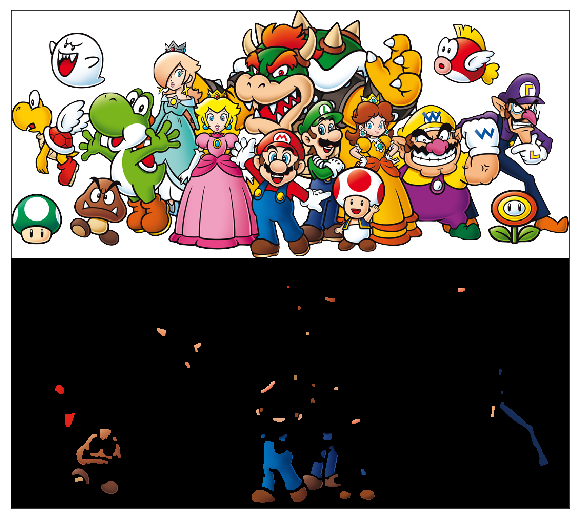

In [34]:
test_rgb = cv2.imread('hist_pics/mario-test.png')
test_rgb = cv2.cvtColor(test_rgb, cv2.COLOR_BGR2RGB)  # make pretty for ipython
test_hsv = cv2.cvtColor(test_rgb, cv2.COLOR_RGB2HSV)  # now convert to HSV
thresh = roiHist.find(test_hsv, 50)
thresh = cv2.merge((thresh,thresh,thresh))  # make 3 channels
res = cv2.bitwise_and(test_rgb,thresh)
pics = np.vstack((test_rgb,res))
plt.imshow(pics);
plt.xticks([]), plt.yticks([]);

# plt.subplot(2,1,1)
# plt.imshow(test_rgb);
# plt.xticks([]), plt.yticks([]);

# plt.subplot(2,1,2)
# plt.imshow(res);
# plt.xticks([]), plt.yticks([]);

Histogram matching alows us to detect much more complex things, but it isn't perfect. How could you maybe improve this?

- We are only looking at color information, but spacial information (relative distances between color groups) would help avoid detections all over the image.
- In real life you could also look at texture of your target (frequency information caused by natural material) to help differentiate Mario's red cloth hat from his red metal car.
- You could add in machine learning and begin to classify things like: Mario pants

Depending on your application and how much processing time you have, there could be other things you could add to this.

# Questions

1. What are the issues, if any, with doing color detection in RGB space?
1. What is the process to do color detection?
1. What is a blob in computer vision terms? *hint* how do you generate a blob?
1. What are the attributes of a blob?
1. What is histogram detection?
1. How do you create a histogram model?
1. Some of the examples worked and some didn't. What could you do to improve the performance of, say, detecting Mario?


-----------

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.